### 18762 - Circuit Simulation <br/> Project 1 <br/> Lucas Godshalk

The simulator's primary logic is divided between two locations, `/classes` and `/lib`. The classes folder contains the implementations for all of the individual circuit elements, while the lib folder contains the main circuit simulation logic. The code doesn't deviate much from the original structure, although one notable addition is the `matrixprovider` class, which handles all matrix operations and swaps between sparse and non-sparse options.

The primary required python packages are `numpy` and `scipy`. You can regenerate this report using the `./build-report.sh` if you are on linux/WSL.

In [1]:
from classes.Settings import Settings
from lib.solve import solve
from matplotlib import pyplot as plt 
from lib.parse_json import parse_json

plt.rcParams['figure.figsize'] = [13, 5]

# Part 1: RL Circuit

In [2]:
rl_devices = parse_json('testcases/RL_circuit.json')
rl_results = solve(rl_devices, Settings())

Running solver (sparse mode: False)...
Circuit has 13 nodes
Total Y matrix size for circuit will be 28
Solver execution complete. Ran for 0.427481568 seconds.


#### RL Output Voltage

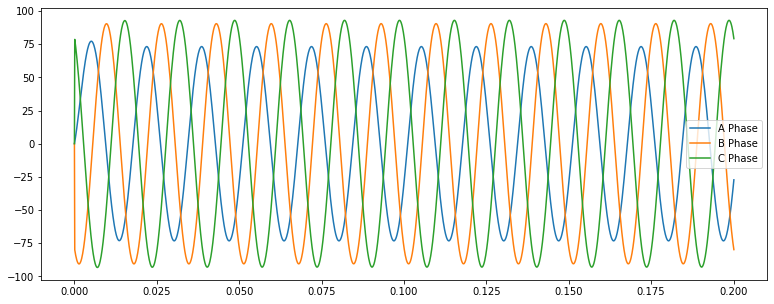

In [3]:
x = rl_results.get_timesteps()
waveforms = [
    (rl_results.get_node_voltage("n3_a"), "A Phase"),
    (rl_results.get_node_voltage("n3_b"), "B Phase"),
    (rl_results.get_node_voltage("n3_c"), "C Phase")
]
for (waveform, label) in waveforms:
    plt.plot(x, waveform, label=label)
plt.legend()
plt.show()

#### RL Output Current

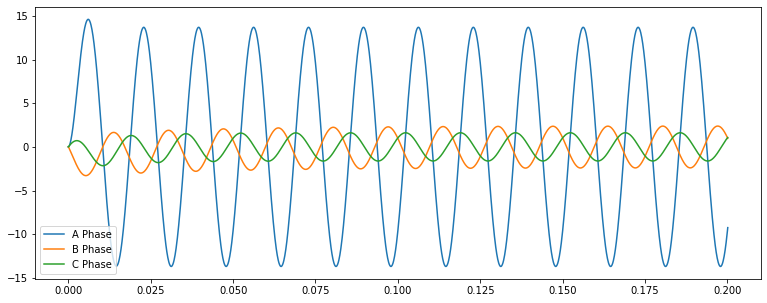

In [4]:
plt.clf()
waveforms = [
    (rl_results.get_current_flow("n4_a", "gnd"), "A Phase"),
    (rl_results.get_current_flow("n4_b", "gnd"), "B Phase"),
    (rl_results.get_current_flow("n4_c", "gnd"), "C Phase")
]
x = rl_results.get_timesteps()
for (waveform, label) in waveforms:
    plt.plot(x, waveform, label=label)
plt.legend()
plt.show()

#### RL Circuit Analysis

Two factors stand out. The first is that the maximum amplitude of the current flow across the A phase is noticably greater than across the B and C phases. This is expected, since the l2_a inductor on the A phase is over an order of magnitude smaller inductance than the matching inductor on the B and C lines, since the change in current scales with the inverse of the inductance. Second, there is a noticable initial surge in the A phase current on the first cycle (with a similar response on the voltage). This is a classic example of the inrush current drawn by energy storage devices.


#### RL Sparse Efficiency

In [5]:
rl_results = solve(rl_devices, Settings(useSparseMatrix=False))
rl_results = solve(rl_devices, Settings(useSparseMatrix=True))

Running solver (sparse mode: False)...
Circuit has 13 nodes
Total Y matrix size for circuit will be 28
Solver execution complete. Ran for 0.658121387 seconds.
Running solver (sparse mode: True)...
Circuit has 13 nodes
Total Y matrix size for circuit will be 28
Solver execution complete. Ran for 0.936336941 seconds.


Note that the non-sparse solver runs faster than the sparse solver. I haven't counted out that I might be using the sparse matrix sub-optimally, but given the (relatively) small matrix size, it could be that other factors can dominate allow the non-sparse matrix to execute faster. As a rule of thumb, sparse data structures tend to be slightly more computationally expensive than their non-sparse peers for small data sets. I would assume that below a certain matrix size, we would see the same here, but I don't know if we've crossed that threshold.

#### RL Simulator Comparison

By comparison, here is a plot of the current from the simulator. While my simulator returned inverted results from mine, the waveform is a close match. It also displays the inrush current, along with the large discrepancy between the A phase versus phases B and C.

![image](./media/RL_circuit_current.png)

# Part 1 (Bonus): RLC Circuit with Switches

In [6]:
rlc_devices = parse_json('testcases/RLC_circuit.json')
rlc_results = solve(rlc_devices, Settings())

Running solver (sparse mode: False)...
Circuit has 16 nodes
Total Y matrix size for circuit will be 52
Solver execution complete. Ran for 0.67909802 seconds.


#### RLC Output Voltage

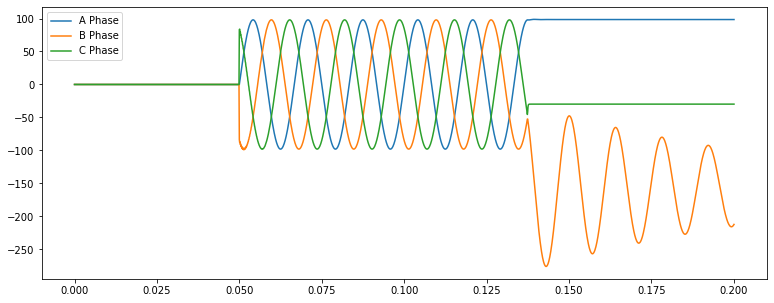

In [7]:
x = rlc_results.get_timesteps()
waveforms = [
    (rlc_results.get_node_voltage("n3_a"), "A Phase"),
    (rlc_results.get_node_voltage("n3_b"), "B Phase"),
    (rlc_results.get_node_voltage("n3_c"), "C Phase")
]
for (waveform, label) in waveforms:
    plt.plot(x, waveform, label=label)
plt.legend()
plt.show()

#### RLC Circuit Analysis

While the voltage plot above is clearly incorrect in a number of respects, the basic switching behavior is visible during the switch operation. Notably missing: any variation in voltage across phases or in the inrush effect when the switch engages. There should also be some kind of trailing effect after the switch closes as the energy dissipates from the circuit.

# Part 2: IM Circuit

In [8]:
im_devices = parse_json('testcases/IM_circuit_debug.json')
im_results = solve(im_devices, Settings(simulationTime=1))

Running solver (sparse mode: False)...
Circuit has 4 nodes
Total Y matrix size for circuit will be 14
Solver execution complete. Ran for 7.513538927 seconds.


#### IM Output Rotor Speed

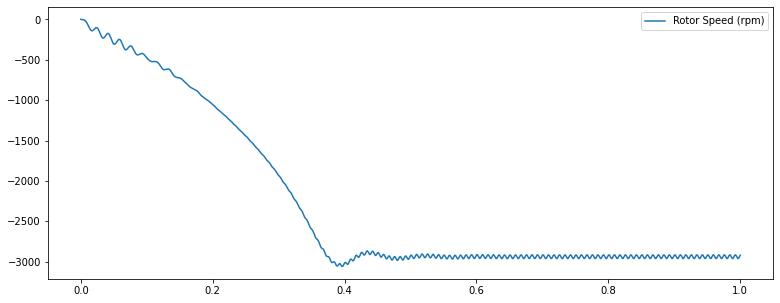

In [9]:
plt.clf()
x = im_results.get_timesteps()
im_waveforms = im_results.get_IM_waveforms("im1")
plt.plot(x, im_waveforms["rpm"], label="Rotor Speed (rpm)")
plt.legend()
plt.show()

#### IM Output Rotor and Stator Currents

##### Stator Currents

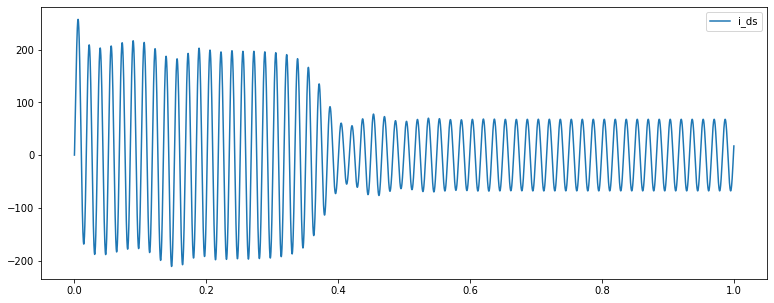

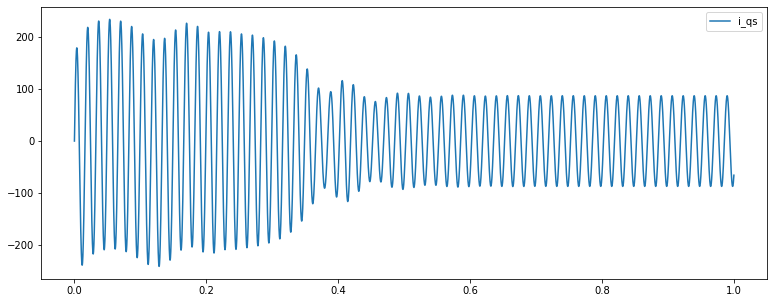

In [10]:
plt.clf()
plt.plot(x, im_waveforms["ids"], label="i_ds")
plt.legend()
plt.show()

plt.clf()
plt.plot(x, im_waveforms["iqs"], label="i_qs")
plt.legend()
plt.show()

##### Rotor Currents

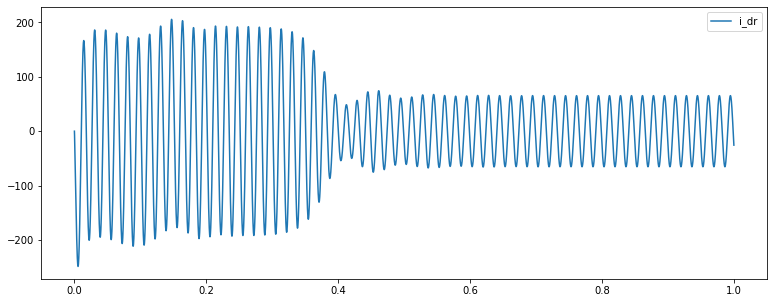

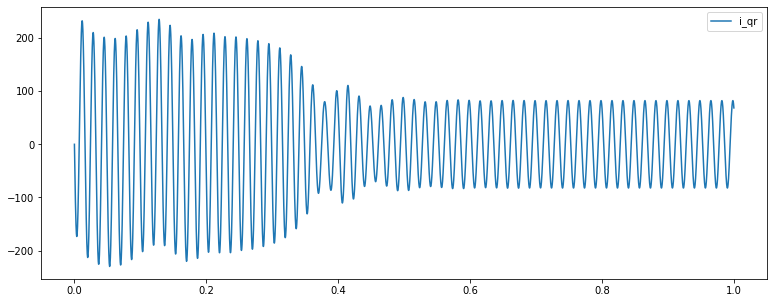

In [11]:
plt.clf()
plt.plot(x, im_waveforms["idr"], label="i_dr")
plt.legend()
plt.show()

plt.clf()
plt.plot(x, im_waveforms["iqr"], label="i_qr")
plt.legend()
plt.show()

#### IM Output Electrical Torque

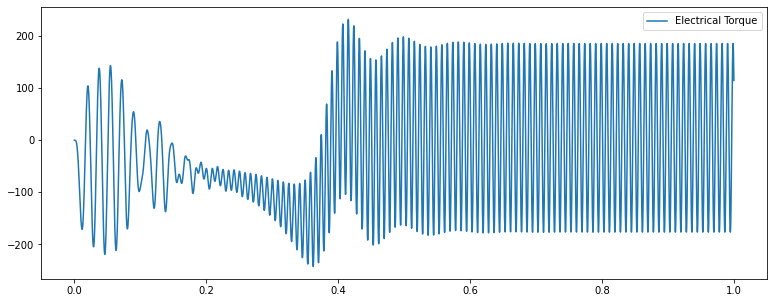

In [12]:
plt.clf()
plt.plot(x, im_waveforms["Te"], label="Electrical Torque")
plt.legend()
plt.show()

#### IM Sparse Efficiency

In [13]:
im_results = solve(im_devices, Settings(simulationTime=0.8, useSparseMatrix=False))
im_results = solve(im_devices, Settings(simulationTime=0.8, useSparseMatrix=True))

Running solver (sparse mode: False)...
Circuit has 4 nodes
Total Y matrix size for circuit will be 14
Solver execution complete. Ran for 6.304372719 seconds.
Running solver (sparse mode: True)...
Circuit has 4 nodes
Total Y matrix size for circuit will be 14
Solver execution complete. Ran for 10.713285001 seconds.


Given the similar matrix size for the IM circuit versus the RL circuit, I would expect any factors that are causing the non-sparse solver to outrun the sparse solver to also be present here. Either a) I'm misuing the sparse library somehow or b) the matrix is small enough that other performance factors can dominate.

# Part 2 (Bonus): IM Switch Circuit

In [14]:
ims_devices = parse_json('testcases/IM_switch_circuit.json')
ims_results = solve(ims_devices, Settings(simulationTime=0.8))

Running solver (sparse mode: False)...
Circuit has 11 nodes
Total Y matrix size for circuit will be 34
Solver execution complete. Ran for 7.442716543 seconds.


#### IM Switch Output Rotor Speed

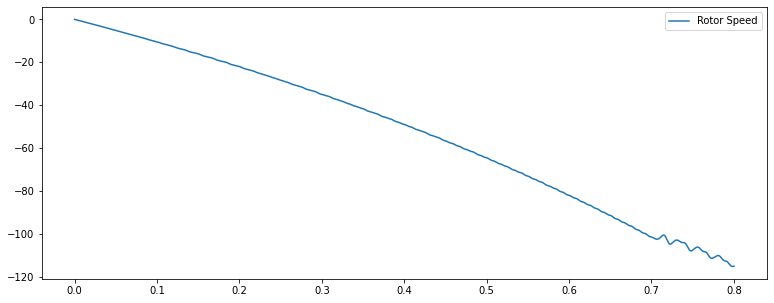

In [15]:
plt.clf()
x = ims_results.get_timesteps()
im_waveforms = ims_results.get_IM_waveforms("im1")
plt.plot(x, im_waveforms["wr"], label="Rotor Speed")
plt.legend()
plt.show()